ATL TWPA simulation program. Response calculated from the generalized CME

In [1]:
# reset the kernel
# %reset -f

# first import python libraries for calculation

from scipy import constants
import numpy as np
import os
from scipy.optimize import fsolve
import math

import warnings
warnings.filterwarnings('ignore', 'Casting complex values to real discards the imaginary part')
warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered in matmul")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered in multiply")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered in scalar multiply")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered in scalar subtract")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered in scalar power")
np.seterr(divide='ignore', invalid='ignore')  # Suppress divide by zero and invalid value warnings

# PLOT parameters
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt


from twpa_design.helper_functions import *
from twpa_design.plots_params import *

In [2]:
# Define ALL parameters with defaults
DEFAULT_CONFIG = {
    # Basic parameters
    'device_name': '4wm_jtwpa',
    'f_step_MHz': 5,
    'fmax_GHz': 30,
    
    # Filter parameters    
    'f_zeros_GHz': [],
    'f_poles_GHz': [],
    'zero_at_zero': True,  # True for low-pass, False for high-pass (only affects pure LP/HP with no finite poles/zeros)
    'fc_filter_GHz': 500,
    'fc_TLsec_GHz': 500,
    'Foster_form_L': 1,
    'Foster_form_C': 1,
    'select_one_form': 'C', # 'L', 'C', or 'both'
    
    # Periodic modulation parameters
    'stopbands_config_GHz': {}, # Dict of {freq_GHz: {'min': val, 'max': val}}
    'force_zero_phase': True, # True for cosine-only (default), False for cosine+sine (Hermitian)
    'window_type': 'boxcar', # 'tukey' Or 'hann', 'boxcar'
    'alpha': 0.0,
    'n_filters_per_sc': 1,
    
    # Nonlinearity parameters
    'nonlinearity': 'JJ',  # 'JJ' or 'KI'
    'Id_uA': 0,
    # Nonlinearity parameters - JJ specific    
    'jj_structure_type': 'jj', # 'jj' or 'rf_squid' 
    'Ic_JJ_uA': 5,
    'fJ_GHz': 40,
    'beta_L': np.inf,
    'phi_dc': 0,        
    # Nonlinearity parameters - KI specific
    'Istar_uA': 100,
    'L0_pH': 100,
    
    # Phase-matching parameters
    'WM': '4WM', # '3WM' or '4WM'
    'dir_prop_PA': 'forw', # 'forw' or 'back'
    'Ia0_uA': 1,
    'detsigidlGHz': 2,
    'fa_min_GHz': 0,
    'fa_max_GHz': 30,
    
    # TWPA line parameters
    'Ntot_cell': 2000,
    'nTLsec': 0,
    'n_jj_struct': 1,
    'Z0_TWPA_ohm': 50,
}

# Device-specific overrides (only what changes from defaults)
DEVICE_CONFIGS = {
    'jtwpa': {
        # Basic parameters
        'device_name': '4wm_jtwpa',
        'fmax_GHz':25,
        # Filter parameters
        'f_zeros_GHz': 9,
        'f_poles_GHz': 8.85,
        'fc_filter_GHz': 200,
        'fc_TLsec_GHz': 200,
        'Foster_form_C': 1,
        'Foster_form_L': 1,
        'select_one_form': 'C',
        # Nonlinearity parameters
        'nonlinearity': 'JJ',
        'jj_structure_type': 'jj',
        'Ic_JJ_uA': 5,
        'fJ_GHz':40,
        # Phase-matching parameters
        'WM': '4WM',
        'dir_prop_PA': 'forw',
        'Ia0_uA': 3,
        'detsigidlGHz': 3,        
        'fa_min_GHz': 7.75,
        'fa_max_GHz': 8.75,
        # TWPA line parameters
        'Ntot_cell': 2000,
        'nTLsec': 10,
    },

    'b_jtwpa': {
        # Basic parameters
        'device_name': 'b_jtwpa',
        'fmax_GHz': 50,
        # Filter parameters
        'f_zeros_GHz': 9.5,
        'f_poles_GHz': [],  # Empty list
        'fc_filter_GHz': 48,        
        'Foster_form_L': 1,
        'Foster_form_C': 1,
        'select_one_form': 'both',
        # Nonlinearity parameters
        'nonlinearity':'JJ',
        'jj_structure_type': 'rf_squid',
        'Ic_JJ_uA': 2,
        'fJ_GHz': 40,
        'beta_L': 0.4,
        'phi_dc': np.pi/2, # Kerr free point for rf-SQUID        
        # Phase-matching parameters
        'WM': '3WM',
        'dir_prop_PA': 'back',
        'Ia0_uA': 2,
        'detsigidlGHz': 0.5,
        'fa_min_GHz': 10,
        'fa_max_GHz': 20,
        # TWPA line parameters
        'Ntot_cell': 2000,
        'nTLsec': 0,
        'n_jj_struct': 1,
    },
    'ktwpa': {
        # Basic parameters
        'device_name': '4wm_ktwpa',
        'fmax_GHz': 40, # 40
        # Filter parameters
        'f_zeros_GHz': 9.8,
        'f_poles_GHz': 9.7,
        'fc_filter_GHz': 500,
        'fc_TLsec_GHz': 500,
        'Foster_form_L': 2,
        'Foster_form_C': 1,        
        'select_one_form': 'L',
        'stopbands_config_GHz': {27: {'max': 4}},  # Stopband at 27 GHz with upper edge at +4 GHz        
        'n_filters_per_sc': 1,  
        # Nonlinearity parameters      
        'nonlinearity': 'KI',
        'Istar_uA': 100,
        'L0_pH': 100,
        # Phase-matching parameters
        'WM': '4WM',
        'dir_prop_PA': 'forw',
        'Ia0_uA': 30,
        'detsigidlGHz': 3,
        'fa_min_GHz': 8.6,
        'fa_max_GHz': 9.6,   
        # TWPA line parameters
        'Ntot_cell': 5000, # 5598
    }
}

In [3]:
# Cell 3: Load Configuration
# ==========================

# Clear potentially conflicting variables from previous runs
variables_to_clear = [
    'LJ0_H', 'CJ_F', 'Ic_JJ_uA',  # JJ-specific
    'c1_taylor', 'c2_taylor', 'c3_taylor', 'c4_taylor', 'epsilon_perA', 'xi_perA2',
    'L0_H',  # Effective inductance for Taylor expansion
    'LinfLF1_H', 'LinfLF1_rem_H', 'C0LF1_F', 'LiLF1_H', 'CiLF1_F',  # Filter arrays
    'L0LF2_H', 'L0LF2_rem_H', 'CinfLF2_F', 'LiLF2_H', 'CiLF2_F',
    'LinfCF1_H', 'C0CF1_F', 'LiCF1_H', 'CiCF1_F',
    'L0CF2_H', 'CinfCF2_F', 'LiCF2_H', 'CiCF2_F',
    'dispersion_type',
    'f_stopbands_GHz', 'deltaf_min_GHz', 'deltaf_max_GHz',  # Derived from stopbands_config_GHz
    'ind_g_C_with_filters', 'n_filters_per_sc', 'width',
    'CTLsec_F', 'LTLsec_H', 'Ncpersc_cell',    
]

for var in variables_to_clear:
    if var in globals():
        del globals()[var]
        print(f"  Cleared {var}")

# Select configuration
simulation_type = "ktwpa"  # Choose: 'jtwpa', 'b_jtwpa', 'ktwpa'

# Optional: Custom parameter overrides
custom_params = {
    # Uncomment to override any parameter:
    # 'Ic_JJ_uA': 2.5,
    # 'Ntot_cell': 1500,
}

# Load configuration
config = DEFAULT_CONFIG.copy()

# Apply device template
if simulation_type in DEVICE_CONFIGS:
    config.update(DEVICE_CONFIGS[simulation_type])
else:
    raise ValueError(f"Unknown simulation type: {simulation_type}. Choose from: {list(DEVICE_CONFIGS.keys())}")

# Apply custom overrides
if 'custom_params' in locals() and custom_params:
    config.update(custom_params)

# Set all parameters as variables (for backward compatibility with shared_functions)
for key, value in config.items():
    globals()[key] = value


# Normalize string parameters to lowercase
string_params_to_normalize = [
    'window_type',           
    'dir_prop_PA',     
]

for param in string_params_to_normalize:
    if param in globals() and isinstance(globals()[param], str):
        globals()[param] = globals()[param].lower()

# Configuration summary
print(f"\n=== Configuration Loaded: {device_name} ===")
print(f"Device type: {simulation_type}")
print(f"Nonlinearity: {nonlinearity} ", end='')
if nonlinearity == 'JJ':
    print(f"({jj_structure_type}, Ic={Ic_JJ_uA}μA)")
else:
    print(f"(Istar={Istar_uA}μA)")
print(f"Wave mixing: {WM}")
print(f"Propagation direction: {dir_prop_PA}")
if custom_params:
    print(f"\nCustom overrides applied: {list(custom_params.keys())}")


=== Configuration Loaded: 4wm_ktwpa ===
Device type: ktwpa
Nonlinearity: KI (Istar=100μA)
Wave mixing: 4WM
Propagation direction: forw


In [4]:
# GENERAL DERIVED QUANTITIES

sig_above_idl = 1

# we have a Butt. 2 LPF prototype for UC: asymetrtic UC
g_L = np.sqrt(2)
g_C = np.sqrt(2)

Z0_ohm = 50  # Impedance

Ia0_A = Ia0_uA * 1E-6  # Convert to Amps from uA for consistency with other currents.    

# Power calculations
Pa_dBm = 10 * np.log10((Ia0_A)**2 * Z0_ohm * 1E3)  # PA pump power


# Vector of frequency
f_GHz = np.arange(f_step_MHz * 1E-3, fmax_GHz + f_step_MHz * 1E-3, f_step_MHz * 1E-3)
w = 2 * np.pi * f_GHz * 1E9
n_f = len(f_GHz)

if nonlinearity == 'JJ':
    
    # Circuit parameters
    Ic_JJ_A = Ic_JJ_uA * 1E-6
    LJ0_H = phi0 / Ic_JJ_A  # Single junction bare inductance
    wJ = 2 * np.pi * fJ_GHz * 1E9
    CJ_F = 1 / (LJ0_H * wJ**2)  # Shunt cap

    Lg_H = beta_L * LJ0_H   # rf-SQUID geometric inductance. Inf if just a jj and no rf-squid.
    
    if jj_structure_type == 'jj':
        phi_ext = 0
        # in the jj case we can still dc bias the jj using Id_uA.
        phi_dc = np.arcsin(Id_uA/Ic_JJ_uA)        
        J_uA = 0

    elif jj_structure_type == 'rf_squid':
        # Calculate bias points        
        phi_ext = phi_dc + beta_L * np.sin(phi_dc)
        Id_uA = phi_ext * phi0 / Lg_H * 1E6 # equivalent current dc bias.        

        # Solve for circulating current
        def circ_current_eq(J):
            return J + Ic_JJ_A * np.sin(phi_ext + beta_L * J / Ic_JJ_A)
        J_uA = np.abs(fsolve(circ_current_eq, 0)[0]) * 1E6

    # coefficients of the current-phase relation. These coeffs don't include the factorial prefactors.
    # at the Kerr-free point c4 = 0.
    # for just a jj, beta_L = Inf and these relations still hold
    c1_currentphase = 1/beta_L + np.cos(phi_dc)
    c2_currentphase = - np.sin(phi_dc)
    c3_currentphase = - np.cos(phi_dc)
    c4_currentphase = np.sin(phi_dc)

    print("Taylor expansion of the current-phase relation at the dc operating point, I_ac/Ic = c1 φ + c2 φ**2 + c3 φ**3 with:")
    print(f"    c1 = {c1_currentphase}")
    print(f"    c2 = {c2_currentphase/math.factorial(2)}")
    print(f"    c3 = {c3_currentphase/math.factorial(3)}")
    print(f"    c4 = {c4_currentphase/math.factorial(4)}")

    epsilon_perA = - c2_currentphase / (c1_currentphase**2) * 1/Ic_JJ_A
    xi_perA2 = (3*c2_currentphase**2 - c1_currentphase*c3_currentphase) / (2*c1_currentphase**4) * 1/(Ic_JJ_A**2)

    # calculates the Taylor coeffs of L(φ)
    # here I define the Josephson inductance as \dot{\phi} = L \dot{I}.
    if jj_structure_type == 'jj':             
        L0_H = LJ0_H        
        c1_taylor = 0.0
        c2_taylor = 1/2
        c3_taylor = 0.0
        c4_taylor = 5/24
    elif jj_structure_type == 'rf_squid':                        
        L0_H = Lg_H / (1 + beta_L * np.cos(phi_dc))                                        
        c1_taylor = beta_L*np.sin(phi_dc)/(1+beta_L*np.cos(phi_dc))
        
        c2_taylor = beta_L*(np.cos(phi_dc) + beta_L*(1+np.sin(phi_dc)**2))/(2*(1+beta_L*np.cos(phi_dc))**2)

        c3_taylor = beta_L*np.sin(phi_dc)*(6*beta_L**2*np.sin(phi_dc)**2 + 5*beta_L**2*np.cos(phi_dc)**2 + 4*beta_L*np.cos(phi_dc)-1
                                                )/(6*(1+beta_L*np.cos(phi_dc))**3)
        
        c4_taylor = beta_L*(-np.cos(phi_dc) + 3*beta_L*np.cos(phi_dc)**2 + 9*beta_L**2*np.cos(phi_dc)**3 + 5*beta_L**3*np.cos(phi_dc)**4
                                -8*beta_L*np.sin(phi_dc)**2 + 20*beta_L**2*np.cos(phi_dc)*np.sin(phi_dc)**2
                                + 28*beta_L**3*np.cos(phi_dc)**2*np.sin(phi_dc)**2 + 24*beta_L**3*np.sin(phi_dc)**4
                                )/(24*(1+beta_L*np.cos(phi_dc))**4) 


    print("Taylor expansion of L(φ) at the dc operating point, L(φ)/L0 = 1 + c1_taylor φ + c2_taylor φ**2 + c3_taylor φ**3 + c4_taylor φ**4 with:")
    print(f"    c1_taylor = {c1_taylor}")
    print(f"    c2_taylor = {c2_taylor}")
    print(f"    c3_taylor = {c3_taylor}")
    print(f"    c4_taylor = {c4_taylor}")


elif nonlinearity == 'KI':

    # (I could also rewrite the code to make these parameters optional in the functions, but it means that 
    # I would have to re-order the parameters in the functions, which is a bit of a hassle)
    n_jj_struct = 1  # this should not be used, but is needed to calculate the filter components    
    CJ_F = np.inf # this should not be used, but is needed to calculate the filter components

    Istar_A = Istar_uA * 1E-6  
    Id_A = Id_uA*1E-6

    epsilon_perA = 2*Id_A/(Istar_A**2+Id_A**2)  
    xi_perA2 = 1/(Istar_A**2+Id_A**2)  

    L0_H = L0_pH * 1E-12

    c1_taylor = phi0/L0_H*epsilon_perA
    c2_taylor = 1/2*(phi0/L0_H)**2*(2*xi_perA2-3*epsilon_perA**2)

    print("Taylor expansion of L(φ) at the dc operating point, L(φ)/L0 = 1 + c1_taylor φ + c2_taylor φ**2 with:")
    print(f"    c1_taylor = {c1_taylor}")
    print(f"    c2_taylor = {c2_taylor}")    

C0_F = L0_H / (Z0_TWPA_ohm**2)

# this is the cutoff without filter
fcmax_GHz = np.sqrt(g_L*g_C) / (2 * np.pi * np.sqrt(L0_H * C0_F)) * 1E-9

Taylor expansion of L(φ) at the dc operating point, L(φ)/L0 = 1 + c1_taylor φ + c2_taylor φ**2 with:
    c1_taylor = 0.0
    c2_taylor = 0.0010831074506828559


In [6]:
# derived quantities depending on the type of dispersion

# extract stopbands configuration from the dict
if isinstance(stopbands_config_GHz, dict) and stopbands_config_GHz:
    # Extract from dict format
    f_stopbands_GHz = list(stopbands_config_GHz.keys())
    deltaf_min_GHz = [config.get('min') for config in stopbands_config_GHz.values()]
    deltaf_max_GHz = [config.get('max') for config in stopbands_config_GHz.values()]
else:
    # Empty case
    f_stopbands_GHz = []
    deltaf_min_GHz = []
    deltaf_max_GHz = []

dispersion_type = derive_dispersion_type(f_zeros_GHz, f_poles_GHz, f_stopbands_GHz)
print(f"\nDispersion type: {dispersion_type}")

if dispersion_type == 'filter' or dispersion_type == 'both':

    # Convert the filter parameters to numpy arrays
    f_zeros_GHz = ensure_numpy_array(f_zeros_GHz)
    f_poles_GHz = ensure_numpy_array(f_poles_GHz)

    try:
        zero_at_zero
    except:
        zero_at_zero = should_have_zero_at_zero(f_zeros_GHz, f_poles_GHz, zero_at_zero)

    try:
        fc_TLsec_GHz
    except:
        fc_TLsec_GHz = fc_filter_GHz

    if fc_filter_GHz > fcmax_GHz:
        fc_filter_GHz = fcmax_GHz
    if fc_TLsec_GHz > fcmax_GHz:
        fc_TLsec_GHz = fcmax_GHz

    wc_filter = 2 * np.pi * fc_filter_GHz * 1E9
    s = 1j * w / wc_filter

    w_zeros = f_zeros_GHz / fc_filter_GHz
    w_poles = f_poles_GHz / fc_filter_GHz

    n_zeros = len(w_zeros)
    n_poles = len(w_poles)

    # Frequency transformation
    lambda_val = frequency_transform(s, w_zeros, w_poles, zero_at_zero)

elif dispersion_type == 'periodic': 

    Foster_form_L = 1 # I arbitrarily set this to 1 for the periodic modulation case
    Foster_form_C = 2 # I arbitrarily set this to 2 for the periodic modulation case

    if fc_TLsec_GHz > fcmax_GHz:
        fc_TLsec_GHz = fcmax_GHz

# Transmission line section design
LTLsec_H = g_L * Z0_TWPA_ohm / (2 * np.pi * fc_TLsec_GHz * 1E9) # L = gL*Z0/wc
L0_total_H = n_jj_struct * L0_H
LTLsec_rem_H = LTLsec_H - L0_total_H
LTLsec_rem_H = max(0, LTLsec_rem_H)
# some numerical precision here:
if LTLsec_rem_H < 1e-20:
    LTLsec_rem_H = 0

if dispersion_type == 'periodic' or dispersion_type == 'both':    

    # periodic modilation derived quantities
    n_stopbands, v_cellpernsec, Ncpersc_cell, w_tilde_stopband_edges, ind_stopband, is_default_value, w_tilde_param, ind_param, max_ind_stopband, n_param, skipped_indices =\
        pl_derived_quantities(f_stopbands_GHz, deltaf_min_GHz, deltaf_max_GHz, fc_TLsec_GHz/np.sqrt(g_L*g_C)) # here the input must be 1/sqrt(LC)
    
    
    ################################################################################################
    # Calculate the delta values for the actual parameters (not the skipped ones)
    delta_c_map, delta_s_map, selected_delta_c, selected_delta_s, modulation_info = calculate_delta_values(
        ind_stopband, ind_param, w_tilde_stopband_edges, is_default_value, max_ind_stopband, n_param, skipped_indices,
        force_zero_phase=True  # Use True for backward-compatible cosine-only mode
    )
    # Backward compatibility aliases
    delta_map = delta_c_map
    selected_delta = selected_delta_c

    nTLsec = 0
    Nsc_cell = int(np.round(Ntot_cell/Ncpersc_cell))
    Ntot_cell = int(Nsc_cell*Ncpersc_cell)

    # this is a choice so that I can use the same code as for the filter case
    if window_type == 'boxcar':
        ngL = Ncpersc_cell
        ngC = Ncpersc_cell
    else:
        ngL = Ntot_cell
        ngC = Ntot_cell 

    # Calculate the cap modulation over the cells - using only non-default stopbands
    x_tilde = np.linspace(0, 1 - 1/Ncpersc_cell, Ncpersc_cell) * 2 * np.pi
    g_C_mod = g_C*np.ones(Ncpersc_cell) # normalized shunt capacitance

    print("Delta mapping for shunt capacitance modulation:")
    for idx in sorted(delta_map.keys()):
        print(f"  mode {idx}: delta_{idx} = {delta_map[idx]:.6f}")

    # Apply the delta values to the corresponding modes
    for idx in range(1, max_ind_stopband + 1):
        if idx in delta_map:  # If this stopband has a delta parameter
            delta_val = delta_map[idx]
            g_C_mod = g_C_mod + 2 * delta_val * np.cos(idx * x_tilde)
            print(f"Applied delta_{idx} = {delta_val:.6f} to mode {idx}")
        else:
            print(f"Skipped mode {idx} (no free parameter)")

    # now applies window
    if window_type == 'boxcar':
        g_C_mod = np.tile(g_C_mod, Nsc_cell)
    else:
        g_C_mod = create_windowed_transmission_line(g_C_mod, Nsc_cell, window_type=window_type, alpha=alpha) 
        
    if window_type == 'tukey':
        width = int(alpha * (Ntot_cell - 1) / 2)     
        width = round(width / Ncpersc_cell) * Ncpersc_cell 
        n_periodic_sc = int((ngC - 2*width)/Ncpersc_cell)    
    else:
        width = 0
        n_periodic_sc = Nsc_cell

    # calculate dimensioned shunt capacitance
    CTLsec_F = g_C_mod / (Z0_TWPA_ohm * 2 * np.pi * fc_TLsec_GHz * 1E9) # C = gC/(Z0 wc)
    
    
if dispersion_type == 'filter':

    nTLsec =  nTLsec & ~1  # Clears the least significant bit to make it even

    ngL = 1
    ngC = 1

    width = 0

    LinfLF1_H, C0LF1_F, LiLF1_H, CiLF1_F, LinfLF1_rem_H,\
    L0LF2_H, CinfLF2_F, LiLF2_H, CiLF2_F, L0LF2_rem_H,\
    LinfCF1_H, C0CF1_F, LiCF1_H, CiCF1_F,\
    L0CF2_H, CinfCF2_F, LiCF2_H, CiCF2_F,\
    maxL_ind_H, maxL_cap_F, maxC_ind_H, maxC_cap_F = \
    calculate_filter_components(Foster_form_L,Foster_form_C,g_L,g_C,w_zeros,w_poles,Z0_TWPA_ohm,fc_filter_GHz,zero_at_zero,L0_total_H,select_one_form)
    if nonlinearity == 'JJ':
        if Foster_form_L == 1:
            ind2jjstruct_ratio = LinfLF1_H / L0_H
        elif Foster_form_L == 2:
            ind2jjstruct_ratio = L0LF2_H / L0_H


    Ncpersc_cell = int(nTLsec + 1) # The filter has one cell
    Nsc_cell = int(np.round(Ntot_cell/Ncpersc_cell))
    Ntot_cell = int(Nsc_cell*Ncpersc_cell)
    
    n_periodic_sc = Nsc_cell

    window_type = 'boxcar'  # I arbitrarily set this for the filter case

    CTLsec_F = g_C / (Z0_TWPA_ohm * 2 * np.pi * fc_TLsec_GHz * 1E9) # C = gC/(Z0 wc)

elif dispersion_type == 'both':
    
    if window_type == 'boxcar':
        # No change for boxcar - no windows
        ind_g_C_with_filters = list(range(Ncpersc_cell // n_filters_per_sc-1, Ncpersc_cell, Ncpersc_cell // n_filters_per_sc))
    else:
        # For windowed cases, exclude filters from window regions
        if window_type == 'tukey' and width > 0:
            # Calculate filter positions for the entire line
            all_filter_positions = list(range(Ntot_cell // (Nsc_cell*n_filters_per_sc)-1, Ntot_cell, Ntot_cell // (Nsc_cell*n_filters_per_sc)))
            
            # Filter out positions in the window regions
            ind_g_C_with_filters = []
            for pos in all_filter_positions:
                if width <= pos < (Ntot_cell - width):
                    # This position is in the periodic (non-windowed) section
                    ind_g_C_with_filters.append(pos)
            
            print(f"Total filter positions: {len(all_filter_positions)}")
            print(f"Filters after excluding windows: {len(ind_g_C_with_filters)}")
            print(f"Excluded {len(all_filter_positions) - len(ind_g_C_with_filters)} filters from window regions")
        else:
            # Other window types or no window
            ind_g_C_with_filters = list(range(Ntot_cell // (Nsc_cell*n_filters_per_sc)-1, Ntot_cell, Ntot_cell // (Nsc_cell*n_filters_per_sc)))

    LinfLF1_H, C0LF1_F, LiLF1_H, CiLF1_F, LinfLF1_rem_H,\
    L0LF2_H, CinfLF2_F, LiLF2_H, CiLF2_F, L0LF2_rem_H,\
    LinfCF1_H, C0CF1_F, LiCF1_H, CiCF1_F,\
    L0CF2_H, CinfCF2_F, LiCF2_H, CiCF2_F,\
    maxL_ind_H, maxL_cap_F, maxC_ind_H, maxC_cap_F = \
    calculate_filter_components(Foster_form_L,Foster_form_C,g_L,g_C_mod[ind_g_C_with_filters],w_zeros,w_poles,Z0_TWPA_ohm,fc_filter_GHz,zero_at_zero,L0_total_H,select_one_form)
    if nonlinearity == 'JJ':
        if Foster_form_L == 1:
            ind2jjstruct_ratio = LinfLF1_H / L0_H
        elif Foster_form_L == 2:
            ind2jjstruct_ratio = L0LF2_H / L0_H


if dispersion_type == 'filter' or dispersion_type == 'both':

    max_ind_H = np.max([maxL_ind_H, maxC_ind_H])
    max_cap_F = np.max([maxL_cap_F, maxC_cap_F])

    # Find indices for poles and zeros
    ind_f_zeros = np.zeros(n_zeros, dtype=int)
    ind_f_poles = np.zeros(n_poles, dtype=int)

    for i in range(n_zeros):
        ind_f_zeros[i] = np.argmin(np.abs(f_GHz - f_zeros_GHz[i]))

    for i in range(n_poles):
        ind_f_poles[i] = np.argmin(np.abs(f_GHz - f_poles_GHz[i]))



Dispersion type: both
Number of designed stopbands: 1
f1_GHz: 27
stopband indices: [1]
Skipped indices: []
phase velocity: 500.0 cells/ns
Length of one supercell: 9 cells
Stopband 1 - Normalized stopband max: 0.5579999999999999
w_tilde_stopband_edges: [0.558]
ind_stopband: [1]
Number of parameters (non-default values): 1
Total number of stopband edges: 1
Default values mask: [False]
Parameters only (w_tilde_param): [0.558]
Parameter indices (ind_param): [1]
Stage 1: Finding approximate solutions (tolerance: 1e-06)...
Running 10 basin-hopping searches for 1 parameters...
Using solution tolerance: 1e-06
Starting point 1/10: [-0.5]
New best solution found (objective value: 2.43e-13)
Found valid solution (attempt 1): [-0.20026965]
Verification:
Det1 = 4.93e-07

Starting point 2/10: [-0.25]
New best solution found (objective value: 2.98e-20)
Found valid solution (attempt 2): [-0.20027641]
Verification:
Det1 = 1.73e-10

Starting point 3/10: [0.]
Found valid solution (attempt 3): [0.20026456

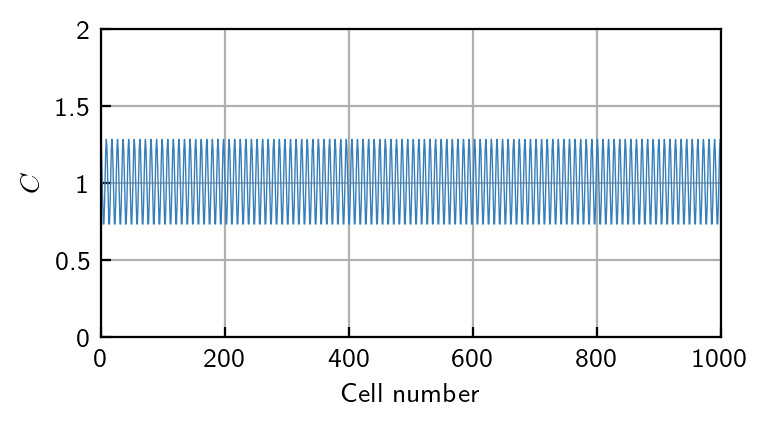

In [7]:
if dispersion_type == 'periodic' or dispersion_type =='both':    
    Nmax2plot_cell = 1000
    if Nmax2plot_cell > Ntot_cell:
        Nmax2plot_cell = Ntot_cell
    fig = plt.figure(figsize=(8.6/2.54, 2))
    # Single plot
    subp = fig.add_subplot(111)
    subp.plot(range(1, Nmax2plot_cell), g_C_mod[1:Nmax2plot_cell]/g_C,linewidth=0.5, color=blue)
    plt.grid(True)  
    plt.xlim([0, Nmax2plot_cell])
    plt.ylim([0, 2])
    plt.xlabel('Cell number')
    # plt.ylabel('$\\tilde{g}_C$')
    plt.ylabel('$C$')
    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

    # Adjust the layout
    # plt.tight_layout()

    fig.set_size_inches(4, 2)
    
    # plt.savefig(os.path.join(os.getcwd(), "4WM-TWPA_apo_profile.svg"), format='svg', bbox_inches='tight')

In [8]:
# LINEAR RESPONSE CALCULATIONS

ABCD_sc = np.zeros((2, 2, n_f), dtype=complex)
ABCD = np.zeros((2, 2, n_f), dtype=complex)

if dispersion_type == 'filter':
    
    ABCD_TLsec = np.zeros((2, 2, n_f), dtype=complex)

    # Calculate transfer matrices
    for i in range(n_f):
        # TL section
        if nTLsec != 0:    
            ABCD_TLsec[:,:,i] = calculate_ABCD_TLsec(L0_H,n_jj_struct,CJ_F,LTLsec_rem_H,CTLsec_F,w[i],LTLsec_H,nonlinearity)                
        
        ABCD_filter = get_ABCD_filter(Foster_form_L,Foster_form_C,L0_H,n_jj_struct,CJ_F,C0LF1_F,LiLF1_H,CiLF1_F,LinfLF1_rem_H,
                              L0LF2_H,CinfLF2_F,LiLF2_H,CiLF2_F,
                              LinfCF1_H,C0CF1_F,LiCF1_H,CiCF1_F,
                              L0CF2_H,CinfCF2_F,LiCF2_H,CiCF2_F,
                              w[i],n_poles,n_zeros,LinfLF1_H,nonlinearity)
        
        # Calculate supercell
        ABCD_sc[:,:,i] = np.linalg.matrix_power(ABCD_TLsec[:,:,i], nTLsec//2) @ ABCD_filter @ np.linalg.matrix_power(ABCD_TLsec[:,:,i], nTLsec//2)

        ABCD[:,:,i] = np.linalg.matrix_power(ABCD_sc[:,:,i], Nsc_cell)
    
elif dispersion_type == 'periodic' and window_type == 'boxcar':      
    for i in range(n_f):
        ABCD_sc[:,:,i] = np.eye(2)                         
        for j in range(ngC):                
            ABCD_filter = calculate_ABCD_TLsec(L0_H,n_jj_struct,CJ_F,LTLsec_rem_H,CTLsec_F[j],w[i],LTLsec_H,nonlinearity)       
            ABCD_sc[:,:,i] = ABCD_sc[:,:,i] @ ABCD_filter

        ABCD[:,:,i] = np.linalg.matrix_power(ABCD_sc[:,:,i], Nsc_cell)


elif dispersion_type == 'periodic' and window_type != 'boxcar':      
    for i in range(n_f):
        ABCD[:,:,i] = np.eye(2)  
        ABCD_sc[:,:,i] = np.eye(2)        
        idx_cell = 0
        # do the first window part
        for j in range(width):                        
            ABCD_filter = calculate_ABCD_TLsec(L0_H,n_jj_struct,CJ_F,LTLsec_rem_H,CTLsec_F[idx_cell],w[i],LTLsec_H,nonlinearity)                       
            ABCD[:,:,i] = ABCD[:,:,i] @ ABCD_filter
            idx_cell += 1
        # then do the periodic parts
        ABCD_filter = np.eye(2)               
        for j in range(Ncpersc_cell):            
            ABCD_periodic_sec = calculate_ABCD_TLsec(L0_H,n_jj_struct,CJ_F,LTLsec_rem_H,CTLsec_F[idx_cell],w[i],LTLsec_H,nonlinearity)                            
            ABCD_filter = ABCD_filter @ ABCD_periodic_sec
            idx_cell += 1
        ABCD_sc[:,:,i] = ABCD_sc[:,:,i] @ ABCD_filter
        ABCD[:,:,i] = ABCD[:,:,i] @ np.linalg.matrix_power(ABCD_filter, n_periodic_sc)

        idx_cell += Ncpersc_cell*(n_periodic_sc-1)     
        # now do the last part 
        for j in range(width):                        
            ABCD_filter = calculate_ABCD_TLsec(L0_H,n_jj_struct,CJ_F,LTLsec_rem_H,CTLsec_F[idx_cell],w[i],LTLsec_H,nonlinearity)                                 
            ABCD[:,:,i] = ABCD[:,:,i] @ ABCD_filter
            idx_cell += 1 

elif dispersion_type == 'both' and window_type == 'boxcar':    
    for i in range(n_f):
        ABCD_sc[:,:,i] = np.eye(2)        
        p = 0
        for j in range(ngC):            
            if j in ind_g_C_with_filters:                
                # Filter sections
                ABCD_filter = get_ABCD_filter(Foster_form_L,Foster_form_C,L0_H,n_jj_struct,CJ_F,C0LF1_F,LiLF1_H,CiLF1_F,LinfLF1_rem_H,
                              L0LF2_H,CinfLF2_F,LiLF2_H,CiLF2_F,
                              LinfCF1_H[p],C0CF1_F[p],LiCF1_H[p],CiCF1_F[p],
                              L0CF2_H[p],CinfCF2_F[p],LiCF2_H[p],CiCF2_F[p],
                              w[i],n_poles,n_zeros,LinfLF1_H,nonlinearity)
                p += 1       
            else:
                ABCD_filter = calculate_ABCD_TLsec(L0_H,n_jj_struct,CJ_F,LTLsec_rem_H,CTLsec_F[j],w[i],LTLsec_H,nonlinearity)              
            ABCD_sc[:,:,i] = ABCD_sc[:,:,i] @ ABCD_filter

        ABCD[:,:,i] = np.linalg.matrix_power(ABCD_sc[:,:,i], Nsc_cell)

# in this last case I build ABCD and ABCD_sc separately
elif dispersion_type == 'both' and window_type != 'boxcar':
    for i in range(n_f):
        ABCD[:,:,i] = np.eye(2)  
        ABCD_sc[:,:,i] = np.eye(2)        
        p = 0
        idx_cell = 0
        # do the first window part
        for j in range(width):            
            if idx_cell in ind_g_C_with_filters:                
                # Filter sections
                ABCD_filter = get_ABCD_filter(Foster_form_L,Foster_form_C,L0_H,n_jj_struct,CJ_F,C0LF1_F,LiLF1_H,CiLF1_F,LinfLF1_rem_H,
                              L0LF2_H,CinfLF2_F,LiLF2_H,CiLF2_F,
                              LinfCF1_H[p],C0CF1_F[p],LiCF1_H[p],CiCF1_F[p],
                              L0CF2_H[p],CinfCF2_F[p],LiCF2_H[p],CiCF2_F[p],
                              w[i],n_poles,n_zeros,LinfLF1_H,nonlinearity)       
                p += 1
            else:
                ABCD_filter = calculate_ABCD_TLsec(L0_H,n_jj_struct,CJ_F,LTLsec_rem_H,CTLsec_F[idx_cell],w[i],LTLsec_H,nonlinearity)                       
            ABCD[:,:,i] = ABCD[:,:,i] @ ABCD_filter
            idx_cell += 1
        # then do the periodic parts
        ABCD_filter = np.eye(2)               
        for j in range(Ncpersc_cell):
            if idx_cell in ind_g_C_with_filters:
                # Filter sections
                ABCD_periodic_sec = get_ABCD_filter(Foster_form_L,Foster_form_C,L0_H,n_jj_struct,CJ_F,C0LF1_F,LiLF1_H,CiLF1_F,LinfLF1_rem_H,
                              L0LF2_H,CinfLF2_F,LiLF2_H,CiLF2_F,
                              LinfCF1_H[p],C0CF1_F[p],LiCF1_H[p],CiCF1_F[p],
                              L0CF2_H[p],CinfCF2_F[p],LiCF2_H[p],CiCF2_F[p],
                              w[i],n_poles,n_zeros,LinfLF1_H,nonlinearity)             
                p += 1
            else:
                ABCD_periodic_sec = calculate_ABCD_TLsec(L0_H,n_jj_struct,CJ_F,LTLsec_rem_H,CTLsec_F[idx_cell],w[i],LTLsec_H,nonlinearity)                
            
            ABCD_filter = ABCD_filter @ ABCD_periodic_sec
            idx_cell += 1

        ABCD_sc[:,:,i] = ABCD_sc[:,:,i] @ ABCD_filter
        ABCD[:,:,i] = ABCD[:,:,i] @ np.linalg.matrix_power(ABCD_filter, n_periodic_sc)

        idx_cell += Ncpersc_cell*(n_periodic_sc-1)
        p += n_filters_per_sc*(n_periodic_sc-1)        

        # now do the last window part       
        for j in range(width):            
            if idx_cell in ind_g_C_with_filters:                
                # Filter sections

                ABCD_filter = get_ABCD_filter(Foster_form_L,Foster_form_C,L0_H,n_jj_struct,CJ_F,C0LF1_F,LiLF1_H,CiLF1_F,LinfLF1_rem_H,
                              L0LF2_H,CinfLF2_F,LiLF2_H,CiLF2_F,
                              LinfCF1_H[p],C0CF1_F[p],LiCF1_H[p],CiCF1_F[p],
                              L0CF2_H[p],CinfCF2_F[p],LiCF2_H[p],CiCF2_F[p],
                              w[i],n_poles,n_zeros,LinfLF1_H,nonlinearity)      
                p += 1
            else:
                ABCD_filter = calculate_ABCD_TLsec(L0_H,n_jj_struct,CJ_F,LTLsec_rem_H,CTLsec_F[idx_cell],w[i],LTLsec_H,nonlinearity)                                 
            ABCD[:,:,i] = ABCD[:,:,i] @ ABCD_filter
            idx_cell += 1                                

        
with np.errstate(over='ignore'):
    S21 = 2 / (ABCD[0,0,:] + ABCD[0,1,:]/Z0_ohm + ABCD[1,0,:]*Z0_ohm + ABCD[1,1,:])


# Calculate Bloch impedance. This is a property of the infinite ATL. So always calculated from the supercell
# it excludes windowing effects.
Zbloch_ohm = np.abs(np.real(
    (ABCD_sc[0,0,:] - ABCD_sc[1,1,:] + np.sqrt((ABCD_sc[1,1,:] + ABCD_sc[0,0,:] - 2) * 
                                                (ABCD_sc[1,1,:] + ABCD_sc[0,0,:] + 2))) / (2 * ABCD_sc[1,0,:])
))


In [9]:
# calculate k

# commmon to all 3 situations
k_radpersc = np.zeros(n_f)
for i in range(n_f):
    # The sign of C tells us which spatial harmonic we're on
    sign_val = np.sign(np.imag(ABCD_sc[1,0,i])) if np.imag(ABCD_sc[1,0,i]) != 0 else 1
    k_radpersc[i] = sign_val * np.imag(np.arccosh((ABCD_sc[0,0,i]+ABCD_sc[1,1,i])/2))


if dispersion_type == 'filter':

    # in the filter case we don't need to unwrap: the phase if fully defined between -pi and pi for one supercell
    k_radpercell = k_radpersc / Ncpersc_cell
    
    # Find true zeros
    inds_true_zeros = np.ones(n_zeros, dtype=int)
    if nTLsec != 0:
        if zero_at_zero:
            for i in range(n_zeros):
                if i+1 <= n_poles-1: # Then there is a pole at non-infinity following the zero
                    search_range = k_radpercell[ind_f_poles[i]:ind_f_poles[i+1]]
                    inds_true_zeros[i] = np.argmin(np.abs(search_range)) + ind_f_poles[i]
                else:
                    search_range = k_radpercell[ind_f_poles[i]:]
                    inds_true_zeros[i] = np.argmin(np.abs(search_range)) + ind_f_poles[i]
    else:
        for i in range(n_zeros):
            inds_true_zeros[i] = np.argmin(np.abs(f_GHz - f_zeros_GHz[i]))

if dispersion_type == 'periodic':

    # in the periodic case we need to unwrap because we "jump" from one spatial harmonic to the next
    # the phase of k_radpersc is litterally wrapped between -pi/d and pi/d
    k_radpercell = np.unwrap(k_radpersc) / Ncpersc_cell

elif dispersion_type == 'both':

    # we can't unwrap here, because it would also (wrongly) unwrap the filters within each branches
    # Instead, we need to shift the overall phase of each branch such that the phase at the stopband frequency is a multiple of pi

    # Find indices of stopband frequencies
    idx_stopband_freqs = np.argmin(np.abs(f_GHz[:, None] - f_stopbands_GHz), axis=0)
    idx_stopband_freqs = np.sort(idx_stopband_freqs)

    # Define thresholds
    re_gamma_threshold = 0.001  # Threshold for being "outside" the stopband (real part of gamma)
    jump_threshold = np.pi/2   # Threshold for detecting a significant jump in k_radpersc
    
    # Process each stopband
    for i in range(len(idx_stopband_freqs)):        
        idx_center = idx_stopband_freqs[i]        
        
        # The phase at the stopband center should be (i+1)*pi
        target_k_at_stopband = (i+1) * np.pi

        # Now scan rightward from the stopband center, correcting any jumps
        idx = idx_center
        while idx < n_f - 1:
            # Check if we're still in the stopband
            re_gamma = np.abs(np.real(np.arccosh((ABCD_sc[0,0,idx]+ABCD_sc[1,1,idx])/2)))

             # If we're outside the stopband, we're done with this stopband
            if re_gamma < re_gamma_threshold:
                break

            # Check if k at this point needs correction
            current_k = k_radpersc[idx]
            
            if np.abs(current_k - target_k_at_stopband) > jump_threshold:
                # Apply correction to this point and everything to the right
                shift = target_k_at_stopband - current_k
                k_radpersc[idx:] += shift
                
            idx += 1

        # Now scan leftward from the stopband center (for aesthetics)
        idx = idx_center - 1
        while idx >= 0:
            # Check if we're still in the stopband
            re_gamma = np.abs(np.real(np.arccosh((ABCD_sc[0,0,idx]+ABCD_sc[1,1,idx])/2)))

            # If we're outside the stopband, we're done with this direction
            if re_gamma < re_gamma_threshold:
                break

            # Check if k at this point needs correction
            current_k = k_radpersc[idx]
            
            if np.abs(current_k - target_k_at_stopband) > jump_threshold:
                # Only correct this single point (not the whole left side)
                shift = target_k_at_stopband - current_k
                k_radpersc[idx] += shift
                
            idx -= 1
        
    
    k_radpercell = k_radpersc / Ncpersc_cell

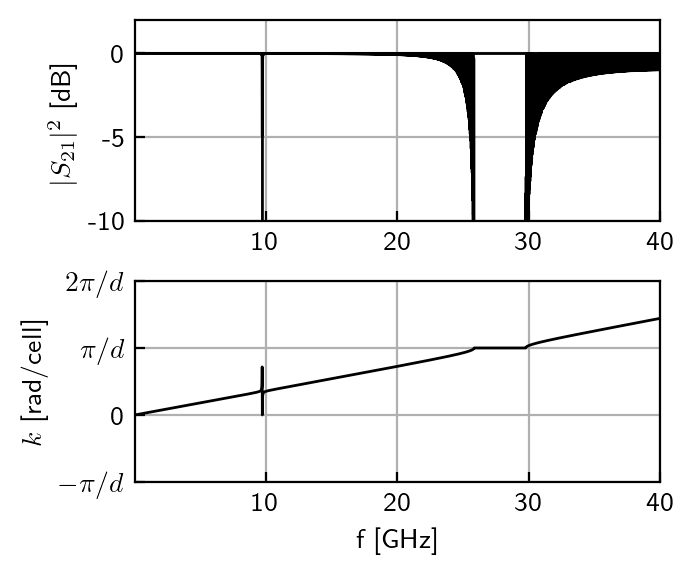

In [10]:
# plot linear response of the ATL

fig = plt.figure(figsize=(8.6/2.54, 3))
fig.subplots_adjust(hspace=0.3)

# First subplot
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(f_GHz, 20*np.log10(np.abs(S21)), color='k', linewidth=linewidth)   
ax1.set_xlim([min(f_GHz), max(f_GHz)])
# ax1.set_xlim([0, 20])
# ax1.set_xlabel('f [GHz]')
ax1.axhline(y=0, color='k', linestyle='-')
ax1.set_ylim([-10, 2])
ax1.set_ylabel(r'$|S_{21}|^2$ [dB]')
ax1.grid(True)

ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))


# Second subplot
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(f_GHz, k_radpercell, color=black, linewidth=1)
ax2.set_xlim([min(f_GHz), max(f_GHz)])
if dispersion_type != 'filter':
    ymin = (np.min(ind_param) - 2) * np.pi/Ncpersc_cell 
    ymax = (np.max(ind_param) + 1) * np.pi/Ncpersc_cell 
else:
    ymin = -np.pi/Ncpersc_cell
    ymax = np.pi/Ncpersc_cell
plt.ylim(ymin, ymax)
# Calculate multiples
# Calculate multiples
min_n = int(np.round(ymin / (np.pi/Ncpersc_cell)))
max_n = int(np.round(ymax / (np.pi/Ncpersc_cell)))
# Set ticks and labels
if dispersion_type != 'filter':
    n_values = np.arange(min_n, max_n + 1)
    tick_positions = n_values * np.pi/Ncpersc_cell
    tick_labels = ['0' if n == 0 else f'${n}\\pi/d$' if n not in [-1, 1] else '$\\pi/d$' if n == 1 else '$-\\pi/d$' for n in n_values]
else:
    # For filter case, use half-integer steps
    n_values = np.arange(min_n * 2, max_n * 2 + 1) / 2  # This gives -1, -0.5, 0, 0.5, 1, etc.
    tick_positions = n_values * np.pi/Ncpersc_cell
    tick_labels = []
    for n in n_values:
        if n == 0:
            tick_labels.append('0')
        elif n == 1:
            tick_labels.append('$\\pi$')
        elif n == -1:
            tick_labels.append('$-\\pi$')
        elif n == 0.5:
            tick_labels.append('$\\pi/2$')
        elif n == -0.5:
            tick_labels.append('$-\\pi/2$')
        else:
            tick_labels.append(f'${int(n*2)}\\pi/2$')
plt.yticks(tick_positions, tick_labels)
ax2.set_xlabel('f [GHz]')
ax2.set_ylabel(r'$k$ [rad/cell]')
ax2.grid(True)

ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

In [30]:
# Phase matching calculation
ind_fa_min = np.argmin(np.abs(f_GHz - fa_min_GHz))
ind_fa_max = np.argmin(np.abs(f_GHz - fa_max_GHz))

delta_kPA = np.zeros(ind_fa_max - ind_fa_min)
delta_betaPA = np.zeros(ind_fa_max - ind_fa_min)

for i in range(ind_fa_min, ind_fa_max):
    if WM == '3WM':
        fs_GHz_val = f_GHz[i] / 2 + sig_above_idl * detsigidlGHz
        fi_GHz_val = f_GHz[i] / 2 - sig_above_idl * detsigidlGHz
    elif WM == '4WM':
        fs_GHz_val = f_GHz[i] + sig_above_idl * detsigidlGHz
        fi_GHz_val = f_GHz[i] - sig_above_idl * detsigidlGHz
    
    ind_sig_val = np.argmin(np.abs(f_GHz - fs_GHz_val))
    ind_idl_val = np.argmin(np.abs(f_GHz - fi_GHz_val))
    
        
    #Ia0_A is roughly what enters the TWPA since it's matched to 50 ohm. This is an approximative PM condition
    idx = i - ind_fa_min
    if WM == '3WM':
        if dir_prop_PA == 'forw':
            delta_kPA[idx] = k_radpercell[i] - k_radpercell[ind_sig_val] - k_radpercell[ind_idl_val]
            delta_betaPA[idx] = delta_kPA[idx] + np.abs(Ia0_A)**2 / 8 * \
                                (xi_perA2 * k_radpercell[i] - 2 * xi_perA2 * k_radpercell[ind_sig_val] - 
                                2 * xi_perA2 * k_radpercell[ind_idl_val])
        elif dir_prop_PA == 'back':
            delta_kPA[idx] = - k_radpercell[i] - k_radpercell[ind_sig_val] - k_radpercell[ind_idl_val]
            delta_betaPA[idx] = delta_kPA[idx] + np.abs(Ia0_A)**2 / 8 * \
                                (- xi_perA2 * k_radpercell[i] - 2 * xi_perA2 * k_radpercell[ind_sig_val] - 
                                2 * xi_perA2 * k_radpercell[ind_idl_val])
    elif WM == '4WM':
        if dir_prop_PA == 'forw':
            delta_kPA[idx] = 2 * k_radpercell[i] - k_radpercell[ind_sig_val] - k_radpercell[ind_idl_val]
            delta_betaPA[idx] = delta_kPA[idx] + xi_perA2 * Ia0_A**2 / 4 * \
                                (k_radpercell[i] - k_radpercell[ind_sig_val] - k_radpercell[ind_idl_val])
        elif dir_prop_PA == 'back':
            delta_kPA[idx] = - 2 * k_radpercell[i] - k_radpercell[ind_sig_val] - k_radpercell[ind_idl_val]
            delta_betaPA[idx] = delta_kPA[idx] + xi_perA2 * Ia0_A**2 / 4 * \
                                (- k_radpercell[i] - k_radpercell[ind_sig_val] - k_radpercell[ind_idl_val])
                            

# Find optimum pump frequency
ind_min_delta_betaPA = np.argsort(np.abs(delta_betaPA))
ind_min_delta_betaPA = ind_min_delta_betaPA + ind_fa_min


ind_PA = ind_min_delta_betaPA[0]
fa_GHz = f_GHz[ind_PA]

# Check that pump frequency is not in stop band
k = 0
while 20 * np.log10(np.abs(S21[ind_PA])) < -20:
    k += 1
    if k >= len(ind_min_delta_betaPA):
        k -= 1
        break
    fa_GHz = f_GHz[ind_min_delta_betaPA[k]]
    ind_PA = np.argmin(np.abs(f_GHz - fa_GHz))


# Calculate signal and idler frequencies
if WM == '3WM':
    fs_GHz = fa_GHz / 2 + sig_above_idl * detsigidlGHz
    fi_GHz = fa_GHz / 2 - sig_above_idl * detsigidlGHz
elif WM == '4WM':
    fs_GHz = fa_GHz + sig_above_idl * detsigidlGHz
    fi_GHz = fa_GHz - sig_above_idl * detsigidlGHz

ind_sig = np.argmin(np.abs(f_GHz - fs_GHz))
ind_idl = np.argmin(np.abs(f_GHz - fi_GHz))

# Calculate phase velocity
if dispersion_type == 'filter':
    if Foster_form_L == 1 and Foster_form_C == 1:
        if C0CF1_F != np.inf and LinfLF1_H != 0:
            v_cellpersec = np.mean(1 / np.sqrt(LinfLF1_H * C0CF1_F))
        elif C0CF1_F == np.inf and LinfLF1_H != 0:
            v_cellpersec = np.mean(1 / np.sqrt(LinfLF1_H * CiCF1_F[0]))
        elif C0CF1_F != np.inf and LinfLF1_H == 0:
            v_cellpersec = np.mean(1 / np.sqrt(LiLF1_H[0] * C0CF1_F))
        elif C0CF1_F == np.inf and LinfLF1_H == 0:
            v_cellpersec = np.mean(1 / np.sqrt(LiLF1_H[0] * CiCF1_F[0]))
    elif Foster_form_L == 1 and Foster_form_C == 2:
        if LinfLF1_H != 0 and CinfCF2_F != 0:
            v_cellpersec = np.mean(1 / np.sqrt(LinfLF1_H * CinfCF2_F))
        elif LinfLF1_H != 0 and CinfCF2_F == 0:
            v_cellpersec = np.mean(1 / np.sqrt(LinfLF1_H * CiCF2_F[0]))
        elif LinfLF1_H == 0 and CinfCF2_F != 0:
            v_cellpersec = np.mean(1 / np.sqrt(LiLF1_H[0] * CinfCF2_F))
        elif LinfLF1_H == 0 and CinfCF2_F == 0:
            v_cellpersec = np.mean(1 / np.sqrt(LiLF1_H[0] * CiCF2_F[0]))
    elif Foster_form_L == 2 and Foster_form_C == 1:
        if L0LF2_H != np.inf and C0CF1_F != np.inf:
            v_cellpersec = np.mean(1 / np.sqrt(L0LF2_H * C0CF1_F))
        elif L0LF2_H == np.inf and C0CF1_F != np.inf:
            v_cellpersec = np.mean(1 / np.sqrt(LiLF2_H[0] * C0CF1_F))
        elif L0LF2_H != np.inf and C0CF1_F == np.inf:
            v_cellpersec = np.mean(1 / np.sqrt(L0LF2_H * CiCF1_F[0]))
        elif L0LF2_H == np.inf and C0CF1_F == np.inf:
            v_cellpersec = np.mean(1 / np.sqrt(LiLF2_H[0] * CiCF1_F[0]))
    elif Foster_form_L == 2 and Foster_form_C == 2:
        if L0LF2_H != np.inf and CinfCF2_F != 0:
            v_cellpersec = np.mean(1 / np.sqrt(L0LF2_H * CinfCF2_F))
        elif L0LF2_H == np.inf and CinfCF2_F != 0:
            v_cellpersec = np.mean(1 / np.sqrt(LiLF2_H[0] * CinfCF2_F))
        elif L0LF2_H != np.inf and CinfCF2_F == 0:
            v_cellpersec = np.mean(1 / np.sqrt(L0LF2_H * CiCF2_F[0]))
        elif L0LF2_H == np.inf and CinfCF2_F == 0:
            v_cellpersec = np.mean(1 / np.sqrt(LiLF2_H[0] * CiCF2_F[0]))        

    # Include transmission line sections
    v_cellpersec = v_cellpersec / Ncpersc_cell + nTLsec / np.sqrt(LTLsec_H * CTLsec_F) / Ncpersc_cell
    v_cellpernsec = v_cellpersec * 1E-9
elif dispersion_type == 'periodic' or dispersion_type == 'both':
    v_cellpersec = v_cellpernsec * 1E9


lambda_PA_cell = v_cellpersec / (fa_GHz * 1E9)  # Length of one PA pump wavelength
l_device_lambda_PA = Ntot_cell / lambda_PA_cell  # Length of the device in PA wavelength

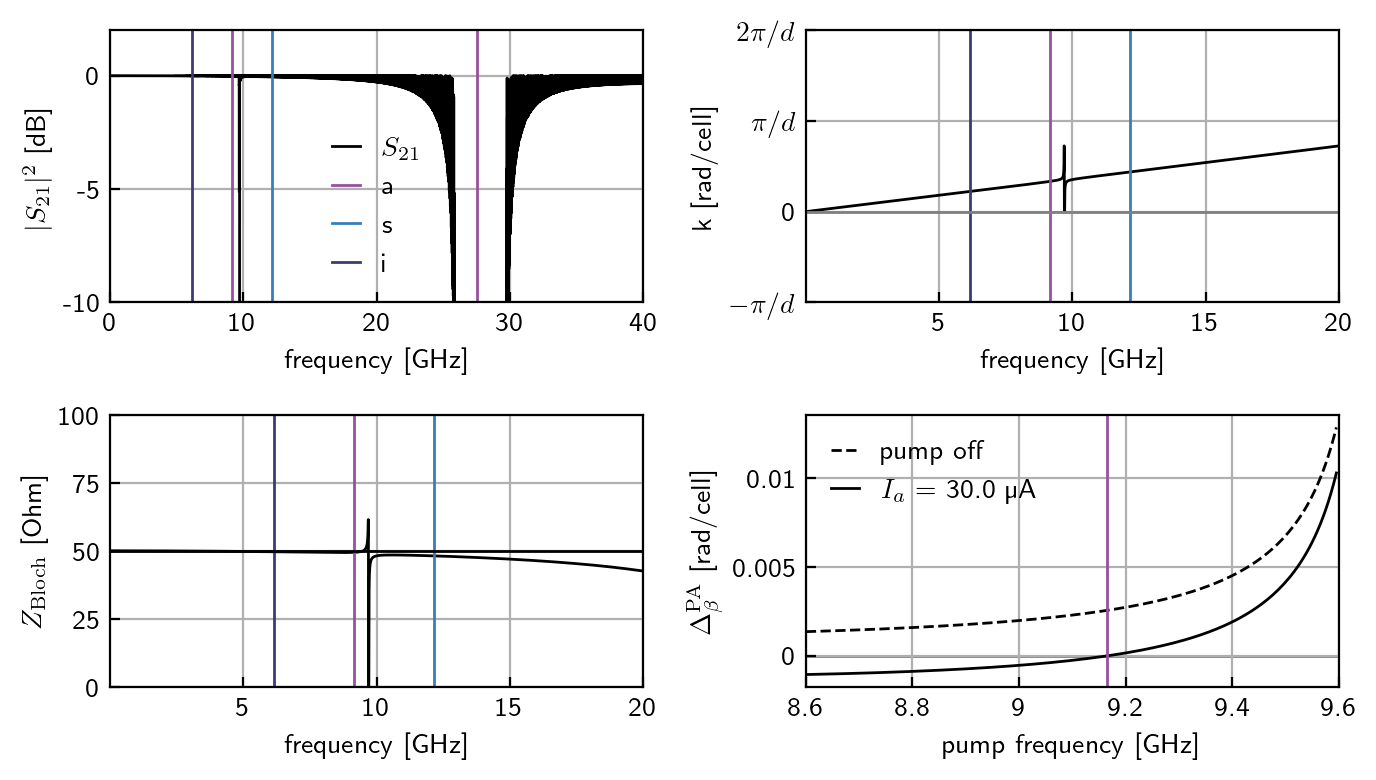

In [31]:
# plot phase matching

linewidth_vert_lines = 1

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(17.8/2.54, 4))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Subplot 1: S21 magnitude in dB
axs[0].set_facecolor('none')
axs[0].plot(f_GHz, 20*np.log10(np.abs(S21)), color=black)
axs[0].axvline(x=fa_GHz, color=purple, linewidth=linewidth_vert_lines)
axs[0].axvline(x=fs_GHz, color=blue, linewidth=linewidth_vert_lines)
axs[0].axvline(x=fi_GHz, color=darkblue, linewidth=linewidth_vert_lines)
if WM == '3WM':
    axs[0].axvline(x=2*fa_GHz,color=purple, linewidth=linewidth_vert_lines)
elif WM == '4WM':
    axs[0].axvline(x=3*fa_GHz,color=purple, linewidth=linewidth_vert_lines)

axs[0].legend(['$S_{21}$', 'a', 's', 'i'], loc='best')
axs[0].set_xlim([0, fmax_GHz])
axs[0].set_ylim([-10, 2])
axs[0].set_xlabel('frequency [GHz]')
axs[0].set_ylabel('$|S_{21}|^2$ [dB]')
axs[0].grid(True)
axs[0].tick_params(labelsize=fontsize)

axs[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

# Subplot 2: k_radpercell
axs[1].set_facecolor('none')
axs[1].plot(f_GHz, k_radpercell, color=black, linewidth=1)
axs[1].axvline(x=fa_GHz, color=purple, linewidth=linewidth_vert_lines)
axs[1].axvline(x=fs_GHz, color=blue, linewidth=linewidth_vert_lines)
axs[1].axvline(x=fi_GHz, color=darkblue, linewidth=linewidth_vert_lines)
if dispersion_type != 'filter':
    ymin = (np.min(ind_param) - 2) * np.pi/Ncpersc_cell
    ymax = (np.max(ind_param) + 1) * np.pi/Ncpersc_cell
else:
    ymin = -np.pi/Ncpersc_cell
    ymax = np.pi/Ncpersc_cell
axs[1].set_ylim(ymin, ymax)
# Calculate multiples
min_n = int(np.round(ymin / (np.pi/Ncpersc_cell)))
max_n = int(np.round(ymax / (np.pi/Ncpersc_cell)))
# Set ticks and labels
if dispersion_type != 'filter':
    n_values = np.arange(min_n, max_n + 1)
    tick_positions = n_values * np.pi/Ncpersc_cell
    tick_labels = ['0' if n == 0 else f'${n}\\pi/d$' if n not in [-1, 1] else '$\\pi/d$' if n == 1 else '$-\\pi/d$' for n in n_values]
else:
    # For filter case, use half-integer steps
    n_values = np.arange(min_n * 2, max_n * 2 + 1) / 2  # This gives -1, -0.5, 0, 0.5, 1, etc.
    tick_positions = n_values * np.pi/Ncpersc_cell
    tick_labels = []
    for n in n_values:
        if n == 0:
            tick_labels.append('0')
        elif n == 1:
            tick_labels.append('$\\pi$')
        elif n == -1:
            tick_labels.append('$-\\pi$')
        elif n == 0.5:
            tick_labels.append('$\\pi/2$')
        elif n == -0.5:
            tick_labels.append('$-\\pi/2$')
        else:
            tick_labels.append(f'${int(n*2)}\\pi/2$')

axs[1].set_yticks(tick_positions)
axs[1].set_yticklabels(tick_labels)
axs[1].set_xlabel('frequency [GHz]')
axs[1].set_ylabel('k [rad/cell]')
axs[1].grid(True)
axs[1].axhline(y=0, color='gray', linestyle='-')

if WM == '3WM':
    axs[1].set_xlim([min(f_GHz), np.floor(fa_GHz/10)*10+10])
elif WM == '4WM':
    axs[1].set_xlim([min(f_GHz), np.floor(2*fa_GHz/10)*10+10])
axs[1].tick_params(labelsize=fontsize)

axs[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))


# Subplot 3: Zbloch_ohm
axs[2].set_facecolor('none')
axs[2].plot(f_GHz, Zbloch_ohm, color=black)
axs[2].axvline(x=fa_GHz, color=purple, linewidth=linewidth_vert_lines)
axs[2].axvline(x=fs_GHz, color=blue, linewidth=linewidth_vert_lines)
axs[2].axvline(x=fi_GHz, color=darkblue, linewidth=linewidth_vert_lines)
axs[2].set_xlabel('frequency [GHz]')
axs[2].set_ylabel('$Z_\\mathrm{Bloch}$ [Ohm]')
axs[2].axhline(y=50, color=black)
axs[2].grid(True)

if WM == '3WM':
    axs[2].set_xlim([min(f_GHz), np.floor(fa_GHz/10)*10+10])
elif WM == '4WM':
    axs[2].set_xlim([min(f_GHz), np.floor(2*fa_GHz/10)*10+10])
axs[2].set_ylim([0, 100])
axs[2].tick_params(labelsize=fontsize)

axs[2].xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
axs[2].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

# Subplot 4: delta_betaPA
axs[3].set_facecolor('none')
if WM == '3WM':    
    axs[3].plot(f_GHz[ind_fa_min:ind_fa_max]/2, np.real(delta_kPA), '--' ,color=black)
    axs[3].plot(f_GHz[ind_fa_min:ind_fa_max]/2, np.real(delta_betaPA), color=black)
    axs[3].set_xlim([f_GHz[ind_fa_min]/2, f_GHz[ind_fa_max]/2])
    axs[3].set_xlabel('half pump frequency [GHz]')
elif WM == '4WM':
    axs[3].plot(f_GHz[ind_fa_min:ind_fa_max], np.real(delta_kPA), '--',color=black)
    axs[3].plot(f_GHz[ind_fa_min:ind_fa_max], np.real(delta_betaPA), color=black)
    axs[3].set_xlim([f_GHz[ind_fa_min], f_GHz[ind_fa_max]])
    axs[3].set_xlabel('pump frequency [GHz]')

if max(np.abs(np.real(delta_betaPA))) > 0.2:
    axs[3].set_ylim([-0.2, 0.2])

axs[3].axhline(y=0, color='gray', linestyle='-', zorder=1)
axs[3].axvline(x=fa_GHz, color=purple, linewidth=linewidth_vert_lines)

axs[3].set_ylabel('$\\Delta_\\beta^\\mathrm{PA}$ [rad/cell]')
axs[3].grid(True)
axs[3].tick_params(labelsize=fontsize)

axs[3].legend(['pump off', f'$I_a$ = {Ia0_uA:.1f} µA'], loc='best')

axs[3].xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
axs[3].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

# Adjust layout to prevent overlapping
plt.tight_layout()

In [32]:
# Output parameters
print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
if nonlinearity == 'JJ':
    print(f'plasma frequency = {fJ_GHz:.2f} GHz')
    print(f'JJ critical current = {Ic_JJ_uA} uA')
    print(f'shunt capacitance = {CJ_F*1E15:.2f} fF')
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(f'phi_dc/(2*pi) that minimizes gamma: phi_dc/(2*pi) = {phi_dc/(2*np.pi):.2f}')
    print(f'it corresponds to phi_ext/(2*pi) = {phi_ext/(2*np.pi):.2f}')
    print(f'it also corresponds to a dc current Id = {Id_uA:.2f} uA')
    print(f'circulating current through the rf-SQUIDs at this bias point J = {J_uA:.2f} uA')    
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(f'n_jj_struct = {n_jj_struct}')
    print(f'ind2jjstruct ratio = {check_flat(ind2jjstruct_ratio,0):.2f}')  # Note: No transpose needed in Python for 1D arrays
elif nonlinearity == 'KI':
    print(f'line cutoff frequency = {fc_TLsec_GHz:.2f} GHz')
    print(f'KI Istar = {Istar_uA:.2f} uA')
    print(f'dc bias Id = {Id_uA:.2f} uA')
print(f'static inductance at the bias point LTLsec_H = {LTLsec_H*1E12:.2f} pH')

if dispersion_type == 'filter' or dispersion_type == 'both':
    print(f'mean capacitance at the bias point CTLsec_F = {np.mean(CTLsec_F)*1E15:.2f} fF')
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(f'pump amplitude: Ia = {Ia0_uA:.2f} uA')
    print(f'phase velocity under bias (at the first transmission zero): v = {np.real(v_cellpernsec):.2f} cell/ns')
    print(f'PA pump wavelength lambda_a= {lambda_PA_cell:.2f} cells')
    print(f'length of the device: l= {l_device_lambda_PA:.2f} lambda_PA')
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    if dispersion_type == 'filter':        
        print(f'zeros at f = {[f"{freq:.2f}" for freq in f_GHz[inds_true_zeros]]} GHz')
    print(f'poles at f = {f_poles_GHz} GHz')
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(f'number of cells per supercell: Ncpersc_cell = {Ncpersc_cell}')
    print(f'total number of cells: Ntot = {Ntot_cell}')
    print(f'number of supercells: Ntot = {Nsc_cell}')
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(f'for signal and idler separated by {2*detsigidlGHz} GHz')
    print(f'phase matched amplification pump frequency: fp = {fa_GHz:.2f} GHz')
    print(f'phase matched signal frequency: fs = {fs_GHz:.2f} GHz')
    print(f'phase matched idler frequency: fi = {fi_GHz:.2f} GHz')
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(f'initial filter cutoff frequency {fc_filter_GHz:.2f} GHz')
    print(f'maximum inductance in the filter {max_ind_H*1E9:.2f} nH')
    print(f'maximum capacitance in the filter {max_cap_F*1E12:.2f} pF')
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
line cutoff frequency = 112.54 GHz
KI Istar = 100.00 uA
dc bias Id = 0.00 uA
static inductance at the bias point LTLsec_H = 100.00 pH
mean capacitance at the bias point CTLsec_F = 40.00 fF
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
pump amplitude: Ia = 30.00 uA
phase velocity under bias (at the first transmission zero): v = 500.00 cell/ns
PA pump wavelength lambda_a= 54.56 cells
length of the device: l= 91.72 lambda_PA
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
poles at f = [9.7] GHz
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
number of cells per supercell: Ncpersc_cell = 9
total number of cells: Ntot = 5004
number of supercells: Ntot = 556
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for signal and idler separated by 6 GHz
phase matched amplification pump frequency: fp = 9.17 GHz
phase matched signal frequency: fs = 12.17 GHz
p

In [ ]:
def export_parameters_to_python(filename=None):
    """Export parameters organized by category to a Python file"""
    
    import os
    from datetime import datetime
    import numpy as np
    from pathlib import Path
    from twpa_design import DESIGNS_DIR
    
    # Get project root and create designs folder path
    designs_folder = DESIGNS_DIR
    designs_folder.mkdir(exist_ok=True)
    
    # Auto-generate filename if not provided
    if filename is None:
        # Simple base pattern without pump amplitude
        base_pattern = f'{device_name}_*.py'
        
        # Use the py-aware filecounter
        full_pattern = os.path.join(designs_folder, base_pattern)
        filename, _ = filecounter(full_pattern)
    else:
        filename = os.path.join(designs_folder, filename)
    
    # Helper function to get value from globals
    def get_param(name, default=None):
        return globals().get(name, default)
    
    # 1. CONFIGURATION PARAMETERS
    config = {}
    
    # Basic parameters (always needed)
    config['device_name'] = get_param('device_name')
    config['f_step_MHz'] = save_parameter_intelligently(get_param('f_step_MHz'))
    config['fmax_GHz'] = save_parameter_intelligently(get_param('fmax_GHz'))
    config['nonlinearity'] = get_param('nonlinearity')
    config['window_type'] = get_param('window_type')
    
    # Filter parameters (only for 'filter' or 'both')
    if dispersion_type in ['filter', 'both']:
        config['f_zeros_GHz'] = save_array_intelligently(get_param('f_zeros_GHz'))
        config['f_poles_GHz'] = save_array_intelligently(get_param('f_poles_GHz'))
        config['fc_filter_GHz'] = save_parameter_intelligently(get_param('fc_filter_GHz'))
        config['fc_TLsec_GHz'] = save_parameter_intelligently(get_param('fc_TLsec_GHz'))
        config['Foster_form_L'] = get_param('Foster_form_L')
        config['Foster_form_C'] = get_param('Foster_form_C')
        config['select_one_form'] = get_param('select_one_form')
    
    # Periodic modulation parameters (only for 'periodic' or 'both')
    if dispersion_type in ['periodic', 'both']:        
        config['stopbands_config_GHz'] = get_param('stopbands_config_GHz')
        config['alpha'] = save_parameter_intelligently(get_param('alpha'))
        config['n_filters_per_sc'] = get_param('n_filters_per_sc')
    
    # JJ-specific parameters (only for JJ nonlinearity)
    if nonlinearity == 'JJ':
        config['jj_structure_type'] = get_param('jj_structure_type')
        config['Ic_JJ_uA'] = save_parameter_intelligently(get_param('Ic_JJ_uA'))
        config['fJ_GHz'] = save_parameter_intelligently(get_param('fJ_GHz'))
        config['beta_L'] = save_parameter_intelligently(get_param('beta_L'))
        config['phi_dc'] = save_parameter_intelligently(get_param('phi_dc'))       
    
    # KI-specific parameters (only for KI nonlinearity)
    elif nonlinearity == 'KI':
        config['Istar_uA'] = save_parameter_intelligently(get_param('Istar_uA'))
        config['Id_uA'] = save_parameter_intelligently(get_param('Id_uA'))
        config['L0_pH'] = save_parameter_intelligently(get_param('L0_pH'))
    
    # Phase-matching parameters (always needed)
    config['WM'] = get_param('WM')
    config['dir_prop_PA'] = get_param('dir_prop_PA')
    config['Ia0_uA'] = save_parameter_intelligently(get_param('Ia0_uA'))
    config['detsigidlGHz'] = save_parameter_intelligently(get_param('detsigidlGHz'))
    config['fa_min_GHz'] = save_parameter_intelligently(get_param('fa_min_GHz'))
    config['fa_max_GHz'] = save_parameter_intelligently(get_param('fa_max_GHz'))
    
    # TWPA line parameters (always needed)
    config['Ntot_cell'] = get_param('Ntot_cell')
    config['nTLsec'] = get_param('nTLsec')
    config['n_jj_struct'] = get_param('n_jj_struct')
    config['Z0_TWPA_ohm'] = save_parameter_intelligently(get_param('Z0_TWPA_ohm'))
    
    # 2. CIRCUIT COMPONENTS
    circuit = {}
    
    circuit['dispersion_type'] = get_param('dispersion_type')

    # Structure parameters (always needed)
    circuit['Nsc_cell'] = get_param('Nsc_cell')
    circuit['Ncpersc_cell'] = get_param('Ncpersc_cell')    
    circuit['ngL'] = get_param('ngL', 1)
    circuit['ngC'] = get_param('ngC', 1)
    
    # Window parameters (only for 'both' with tukey)
    if dispersion_type == 'both' and window_type == 'tukey':
        circuit['width'] = get_param('width')
        circuit['n_periodic_sc'] = get_param('n_periodic_sc')
    else:
        circuit['width'] = get_param('width', 0)
        circuit['n_periodic_sc'] = get_param('n_periodic_sc', Nsc_cell)
    
    # Basic electrical components (always needed)
    circuit['L0_H'] = save_parameter_intelligently(get_param('L0_H'))
    circuit['C0_F'] = save_parameter_intelligently(get_param('C0_F'))
    if nTLsec > 0:
        circuit['LTLsec_H'] = save_parameter_intelligently(get_param('LTLsec_H'))
        circuit['LTLsec_rem_H'] = save_parameter_intelligently(get_param('LTLsec_rem_H'))
        # CTLsec_F - handle differently for periodic vs non-periodic
        if dispersion_type not in ['periodic', 'both']:
            # Only save full CTLsec_F for filter-only case
            circuit['CTLsec_F'] = get_param('CTLsec_F')
    
    # JJ-specific components
    if nonlinearity == 'JJ':
        circuit['LJ0_H'] = get_param('LJ0_H')
        circuit['CJ_F'] = get_param('CJ_F')
        circuit['Lg_H'] = get_param('Lg_H')               
    
    # Nonlinearity coefficients (always needed but different for JJ/KI)  
    circuit['epsilon_perA'] = save_parameter_intelligently(get_param('epsilon_perA'))
    circuit['xi_perA2'] = save_parameter_intelligently(get_param('xi_perA2'))   
    circuit['c1_taylor'] = save_parameter_intelligently(get_param('c1_taylor'))
    circuit['c2_taylor'] = save_parameter_intelligently(get_param('c2_taylor'))
    circuit['c3_taylor'] = save_parameter_intelligently(get_param('c3_taylor'))
    circuit['c4_taylor'] = save_parameter_intelligently(get_param('c4_taylor'))
    
    # Filter components (only for 'filter' or 'both')
    if dispersion_type in ['filter', 'both']:
        circuit['n_zeros'] = get_param('n_zeros')
        circuit['n_poles'] = get_param('n_poles')
        
        # Helper function to ensure array format
        def ensure_array(param_name):
            value = get_param(param_name)
            if value is None:
                return None
            elif isinstance(value, np.ndarray):
                return value
            else:
                # Convert scalar to 1-element array
                return np.array([value])
        
        # Foster 1 components - ensure they're arrays
        circuit['LinfLF1_H'] = save_filter_array_intelligently(ensure_array('LinfLF1_H'))
        circuit['LinfLF1_rem_H'] = save_filter_array_intelligently(ensure_array('LinfLF1_rem_H'))
        circuit['C0LF1_F'] = save_filter_array_intelligently(ensure_array('C0LF1_F'))
        circuit['LiLF1_H'] = save_filter_array_intelligently(get_param('LiLF1_H'))  # These are already 2D arrays
        circuit['CiLF1_F'] = save_filter_array_intelligently(get_param('CiLF1_F'))
        
        # Foster 2 components - ensure they're arrays
        circuit['L0LF2_H'] = save_filter_array_intelligently(ensure_array('L0LF2_H'))
        circuit['L0LF2_rem_H'] = save_filter_array_intelligently(ensure_array('L0LF2_rem_H'))
        circuit['CinfLF2_F'] = save_filter_array_intelligently(ensure_array('CinfLF2_F'))
        circuit['LiLF2_H'] = save_filter_array_intelligently(get_param('LiLF2_H'))  # These are already 2D arrays
        circuit['CiLF2_F'] = save_filter_array_intelligently(get_param('CiLF2_F'))
        
        # Shunt filter components - ensure they're arrays
        circuit['LinfCF1_H'] = save_filter_array_intelligently(ensure_array('LinfCF1_H'))
        circuit['C0CF1_F'] = save_filter_array_intelligently(ensure_array('C0CF1_F'))
        circuit['LiCF1_H'] = save_filter_array_intelligently(get_param('LiCF1_H'))  # These are already 2D arrays
        circuit['CiCF1_F'] = save_filter_array_intelligently(get_param('CiCF1_F'))
        circuit['L0CF2_H'] = save_filter_array_intelligently(ensure_array('L0CF2_H'))
        circuit['CinfCF2_F'] = save_filter_array_intelligently(ensure_array('CinfCF2_F'))
        circuit['LiCF2_H'] = save_filter_array_intelligently(get_param('LiCF2_H'))  # These are already 2D arrays
        circuit['CiCF2_F'] = save_filter_array_intelligently(get_param('CiCF2_F'))
    
    # Periodic modulation arrays (only for 'periodic' or 'both')
    if dispersion_type in ['periodic', 'both']:
        circuit['ind_g_C_with_filters'] = save_filter_array_intelligently(get_param('ind_g_C_with_filters'))
        circuit['n_filters_per_sc'] = get_param('n_filters_per_sc', 0)
        
        # Smart saving for periodic arrays
        CTLsec_F_full = save_filter_array_intelligently(get_param('CTLsec_F'))
        g_C_mod_full = save_filter_array_intelligently(get_param('g_C_mod'))
        
        if window_type == 'boxcar':
            # For boxcar, save only one supercell pattern
            if g_C_mod_full is not None and len(g_C_mod_full) >= Ncpersc_cell:
                circuit['g_C_pattern'] = save_filter_array_intelligently(g_C_mod_full[:Ncpersc_cell])
            else:
                circuit['g_C_pattern'] = save_filter_array_intelligently(g_C_mod_full)
                
            if CTLsec_F_full is not None and hasattr(CTLsec_F_full, '__len__') and len(CTLsec_F_full) >= Ncpersc_cell:
                circuit['CTLsec_pattern'] = save_filter_array_intelligently(CTLsec_F_full[:Ncpersc_cell])
            elif CTLsec_F_full is not None:
                # It's a scalar
                circuit['CTLsec_F'] = save_filter_array_intelligently(CTLsec_F_full)
        else:
            # For windowed cases, save pattern + window data
            width = get_param('width', 0)
            
            if g_C_mod_full is not None and width > 0:
                # Extract the base pattern from the middle (unwindowed) section
                if len(g_C_mod_full) > 2*width + Ncpersc_cell:
                    # Get one supercell from the middle
                    start_idx = width
                    circuit['g_C_pattern'] = save_filter_array_intelligently(g_C_mod_full[start_idx:start_idx + Ncpersc_cell])
                    # Save the windowed parts
                    circuit['g_C_window_start'] = save_filter_array_intelligently(g_C_mod_full[:width])
                    circuit['g_C_window_end'] = save_filter_array_intelligently(g_C_mod_full[-width:])
                else:
                    # If array is too small, just save the pattern
                    circuit['g_C_pattern'] = save_filter_array_intelligently(g_C_mod_full[:Ncpersc_cell]) if len(g_C_mod_full) >= Ncpersc_cell else save_filter_array_intelligently(g_C_mod_full)
            else:
                # No windowing or no g_C_mod
                if g_C_mod_full is not None and len(g_C_mod_full) >= Ncpersc_cell:
                    circuit['g_C_pattern'] = save_filter_array_intelligently(g_C_mod_full[:Ncpersc_cell])
                else:
                    circuit['g_C_pattern'] = save_filter_array_intelligently(g_C_mod_full)
                    
            if CTLsec_F_full is not None and hasattr(CTLsec_F_full, '__len__'):
                if width > 0 and len(CTLsec_F_full) > 2*width + Ncpersc_cell:
                    start_idx = width
                    circuit['CTLsec_pattern'] = save_filter_array_intelligently(CTLsec_F_full[start_idx:start_idx + Ncpersc_cell])
                    circuit['CTLsec_window_start'] = save_filter_array_intelligently(CTLsec_F_full[:width])
                    circuit['CTLsec_window_end'] = save_filter_array_intelligently(CTLsec_F_full[-width:])
                else:
                    circuit['CTLsec_pattern'] = save_filter_array_intelligently(CTLsec_F_full[:Ncpersc_cell]) if len(CTLsec_F_full) >= Ncpersc_cell else save_filter_array_intelligently(CTLsec_F_full)
            elif CTLsec_F_full is not None:
                # It's a scalar
                circuit['CTLsec_F'] = save_filter_array_intelligently(CTLsec_F_full)
            
            # Save window parameters for reconstruction
            if width > 0:
                circuit['window_params'] = {
                    'type': window_type,
                    'alpha': get_param('alpha', 0),
                    'width': width,
                    'n_periodic_sc': get_param('n_periodic_sc'),
                }
    
    # 3. DEVICE CHARACTERISTICS
    characteristics = {}

    
    
    # Frequencies (always calculated)
    characteristics['fa_GHz'] = save_parameter_intelligently(get_param('fa_GHz'))
    characteristics['fs_GHz'] = save_parameter_intelligently(get_param('fs_GHz'))
    characteristics['fi_GHz'] = save_parameter_intelligently(get_param('fi_GHz'))

    # pump amplitude and critical current (for info)
    if nonlinearity == 'JJ':
        characteristics['jj_structure_type'] = get_param('jj_structure_type')
        if jj_structure_type == 'rf_squid':
            characteristics['beta_L'] = save_parameter_intelligently(get_param('beta_L'))
        characteristics['Ic_JJ_uA'] = save_parameter_intelligently(get_param('Ic_JJ_uA'))
    elif nonlinearity == 'KI':
        characteristics['Istar_uA'] = save_parameter_intelligently(get_param('Istar_uA'))
    characteristics['Ia_uA'] = save_parameter_intelligently(get_param('Ia0_uA'))
    
    # Phase velocity and wavelength
    characteristics['v_cellpernsec'] = save_parameter_intelligently(get_param('v_cellpernsec'))
    characteristics['lambda_PA_cell'] = save_parameter_intelligently(get_param('lambda_PA_cell'))
    characteristics['l_device_lambda_PA'] = save_parameter_intelligently(get_param('l_device_lambda_PA'))
    
    # Electrical characteristics
    characteristics['Pa_dBm'] = save_parameter_intelligently(get_param('Pa_dBm'))
    characteristics['fcmax_GHz'] = save_parameter_intelligently(get_param('fcmax_GHz'))
    
    # Filter characteristics (only for 'filter' or 'both')
    if dispersion_type in ['filter', 'both']:
        characteristics['maxL_ind_H'] = save_parameter_intelligently(get_param('maxL_ind_H'))
        characteristics['maxL_cap_F'] = save_parameter_intelligently(get_param('maxL_cap_F'))
        characteristics['maxC_ind_H'] = save_parameter_intelligently(get_param('maxC_ind_H'))
        characteristics['maxC_cap_F'] = save_parameter_intelligently(get_param('maxC_cap_F'))
        characteristics['ind2jjstruct_ratio'] = get_param('ind2jjstruct_ratio')
    
    # JJ-specific characteristics
    if nonlinearity == 'JJ':
        characteristics['phi_dc'] = get_param('phi_dc')
        characteristics['phi_ext'] = get_param('phi_ext')
        characteristics['J_uA'] = get_param('J_uA')

    # Remove None values
    config = {k: v for k, v in config.items() if v is not None}
    circuit = {k: v for k, v in circuit.items() if v is not None}
    characteristics = {k: v for k, v in characteristics.items() if v is not None}
    
    # Write to Python file
    with open(filename, 'w') as f:
        f.write("# Auto-generated TWPA design parameters\n")
        f.write(f"# Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"# Device: {device_name}\n")
        f.write(f"# Nonlinearity: {nonlinearity}\n")
        f.write(f"# Dispersion type: {dispersion_type}\n\n")
        
        f.write("import numpy as np\n\n")
        
        # Write configuration
        f.write("# ========== CONFIGURATION ==========\n")
        f.write("# Parameters defining the TWPA design choices\n\n")
        f.write("config = {\n")
        for key, value in config.items():
            write_parameter(f, key, value)
        f.write("}\n\n")
        
        # Write circuit components
        f.write("# ========== CIRCUIT COMPONENTS ==========\n")
        f.write("# Parameters needed to build the netlist\n\n")
        f.write("circuit = {\n")
        for key, value in circuit.items():
            write_parameter(f, key, value)
        f.write("}\n\n")
        
        # Write characteristics
        f.write("# ========== DEVICE CHARACTERISTICS ==========\n")
        f.write("# Calculated performance parameters\n\n")
        f.write("characteristics = {\n")
        for key, value in characteristics.items():
            write_parameter(f, key, value)
        f.write("}\n")
    
    print(f"✓ Parameters exported to: {filename}")
    print(f"  Configuration parameters: {len(config)}")
    print(f"  Circuit parameters: {len(circuit)}")
    print(f"  Characteristics: {len(characteristics)}")
    
    return filename

def write_parameter(f, key, value):
    """Helper function to write a parameter with proper formatting"""
    
    # List of keys that should always be saved as arrays (even if single element)
    always_array_keys = [
        'LinfLF1_H', 'LinfLF1_rem_H', 'C0LF1_F', 'LiLF1_H', 'CiLF1_F',
        'L0LF2_H', 'L0LF2_rem_H', 'CinfLF2_F', 'LiLF2_H', 'CiLF2_F',
        'LinfCF1_H', 'C0CF1_F', 'LiCF1_H', 'CiCF1_F',
        'L0CF2_H', 'CinfCF2_F', 'LiCF2_H', 'CiCF2_F',
        'f_zeros_GHz', 'f_poles_GHz', 'CTLsec_F', 'g_C_mod',
        'ind_g_C_with_filters'
    ]
    
    if isinstance(value, np.ndarray):
        if value.size == 1 and key not in always_array_keys:
            # Extract single value for non-filter parameters
            single_val = value.item()
            if np.isinf(single_val):
                f.write(f"    '{key}': np.inf,\n")
            elif np.isnan(single_val):
                f.write(f"    '{key}': np.nan,\n")
            else:
                f.write(f"    '{key}': {single_val},\n")
        else:
            # Keep as array (for multi-element or filter arrays)
            if value.ndim == 1:
                # 1D array - manually handle special values
                list_repr = []
                for val in value:
                    if np.isinf(val):
                        list_repr.append('np.inf')
                    elif np.isnan(val):
                        list_repr.append('np.nan')
                    else:
                        list_repr.append(repr(float(val)))
                f.write(f"    '{key}': np.array([{', '.join(list_repr)}]),\n")
            else:
                # Multi-dimensional array - need to handle special values
                def format_nested_list(lst):
                    """Recursively format nested lists with proper np.nan/np.inf"""
                    if isinstance(lst, list):
                        formatted = []
                        for item in lst:
                            formatted.append(format_nested_list(item))
                        return '[' + ', '.join(formatted) + ']'
                    else:
                        # Single value
                        if np.isnan(lst):
                            return 'np.nan'
                        elif np.isinf(lst):
                            return 'np.inf'
                        else:
                            return repr(float(lst))
                
                formatted_array = format_nested_list(value.tolist())
                f.write(f"    '{key}': np.array({formatted_array}),\n")
    elif isinstance(value, (float, np.float64, np.float32)):
        # Check for special float values
        if np.isinf(value):
            f.write(f"    '{key}': np.inf,\n")
        elif np.isnan(value):
            f.write(f"    '{key}': np.nan,\n")
        else:
            f.write(f"    '{key}': {repr(value)},\n")
    elif isinstance(value, str):
        f.write(f"    '{key}': '{value}',\n")
    elif isinstance(value, (list, tuple)):
        # Check list elements for special values
        list_repr = []
        for val in value:
            if isinstance(val, float) and np.isinf(val):
                list_repr.append('np.inf')
            elif isinstance(val, float) and np.isnan(val):
                list_repr.append('np.nan')
            else:
                list_repr.append(repr(val))
        f.write(f"    '{key}': [{', '.join(list_repr)}],\n")
    else:
        f.write(f"    '{key}': {repr(value)},\n")

# Call the export function
export_parameters_to_python()

✓ Parameters exported to: C:\Users\mbm2\OneDrive - NIST\theory\twpa_design\src\twpa_design\designs\4wm_ktwpa_01.py
  Configuration parameters: 28
  Circuit parameters: 39
  Characteristics: 14


'C:\\Users\\mbm2\\OneDrive - NIST\\theory\\twpa_design\\src\\twpa_design\\designs\\4wm_ktwpa_01.py'